In [1]:
import json
import numpy as np
import pandas as pd
from superlink.superlink import SuperLink
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('husl')
%matplotlib inline

In [2]:
with open('../data/six_pipes.json', 'r') as j:
    inp = json.load(j)
    
superjunctions = pd.DataFrame(inp['superjunctions'])
superlinks = pd.DataFrame(inp['superlinks'])
junctions = pd.DataFrame(inp['junctions'])
links = pd.DataFrame(inp['links'])

In [3]:
def triangle(t, lm=1, rm=1, tc=0, yc=1):
    """
    Generate a triangular signal at time t.
    """
    lm = np.asarray(lm)
    rm = np.asarray(rm)
    tc = np.asarray(tc)
    yc = np.asarray(yc)
    if t < tc:
        return np.maximum(yc - (lm)*(-t + tc), 0)
    else:
        return np.maximum(yc - (rm)*(t - tc), 0)

In [4]:
superlink = SuperLink(superlinks, superjunctions, links, junctions, dt=1e-6)    

In [5]:
# Specify time step
dt = 30

# Specify superjunctions with boundary conditions
bc_junctions = np.asarray([0, 0, 0, 1, 0, 1], dtype=float)
# Specify rate of head rise at boundary junctions
H_j_0 = np.copy(superlink.H_j)
dHdt_rise = (1 / 60 / 60) * bc_junctions
dHdt_fall = (2.5 / 240 / 60) * bc_junctions
t_Hc = 2 * 3600
H_max = (dHdt_rise * 2 * 3600) + H_j_0

# Specify rate of inflow at input junctions
dQdt = np.array([0.5, 0, 0.3, 0, 0, 0]) / 60 / 60
t_Qc = 3 * 3600
Q_max = dQdt * 1 * 3600

# Initialize time at zero
t = 0
# End simulation at eight hours
T = 6 * 3600

# Create lists to store results
hs = []
Hs = []
Qs = []
ts = []
Q_ins = []
H_bcs = []

for _ in range(T // dt):
    t += dt
    H_bc = triangle(t, lm=dHdt_rise, rm=dHdt_fall,
                    tc=t_Hc, yc=H_max)
    Q_0j = triangle(t, lm=dQdt, rm=dQdt, tc=t_Qc, yc=Q_max)
    superlink.step(H_bc=H_bc, Q_0j=Q_0j, dt=dt)
    # Store results
    ts.append(t)
    hs.append(np.copy(superlink._h_Ik))
    Hs.append(superlink.H_j)
    Qs.append((superlink._Q_uk + superlink._Q_dk) / 2)
    Q_ins.append(Q_0j)
    H_bcs.append(H_bc)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [6]:
Q = np.vstack(Qs)
H = np.vstack(Hs)
Q_in = np.vstack(Q_ins)
H_bc = np.vstack(H_bcs)
ts = np.asarray(ts)

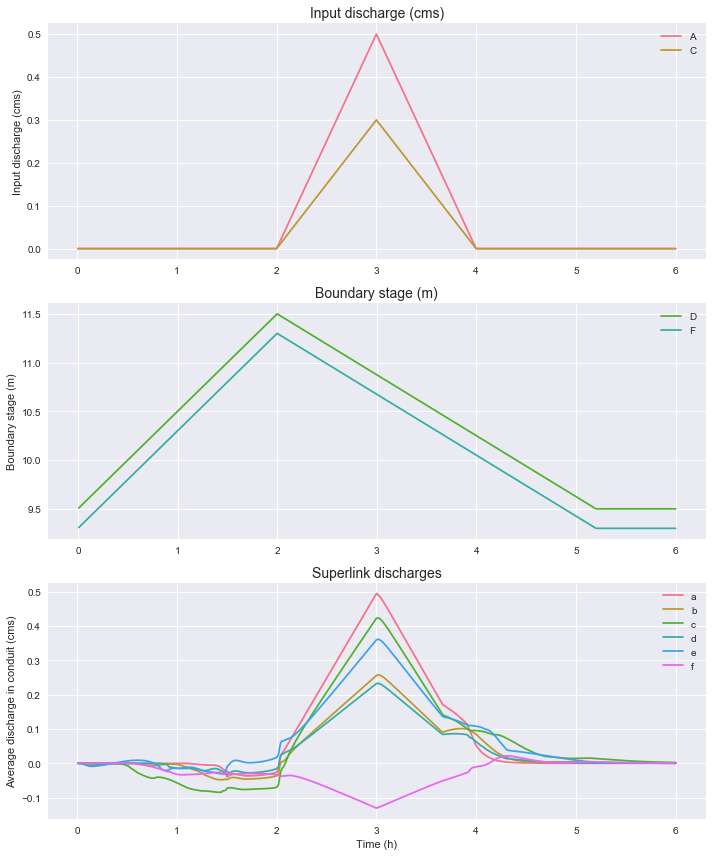

In [7]:
fig, ax = plt.subplots(3, figsize=(10, 12))
ax[0].plot(ts / 3600, Q_in[:,0], label='A')
ax[0].plot(ts / 3600, Q_in[:,2], label='C')
ax[0].set_title('Input discharge (cms)', size=14)
ax[0].set_ylabel('Input discharge (cms)')
ax[0].legend()
ax[1].plot([0], [10])
ax[1].plot([0], [10])
ax[1].plot(ts / 3600, H[:,3], label='D')
ax[1].plot(ts / 3600, H[:,5], label='F')
ax[1].set_title('Boundary stage (m)', size=14)
ax[1].set_ylabel('Boundary stage (m)')
ax[1].legend()
ax[2].plot(ts / 3600, Q[:,0], label='a')
ax[2].plot(ts / 3600, Q[:,1], label='b')
ax[2].plot(ts / 3600, Q[:,2], label='c')
ax[2].plot(ts / 3600, Q[:,3], label='d')
ax[2].plot(ts / 3600, Q[:,4], label='e')
ax[2].plot(ts / 3600, Q[:,5], label='f')
ax[2].set_title('Superlink discharges', size=14)
ax[2].set_xlabel('Time (h)')
ax[2].set_ylabel('Average discharge in conduit (cms)')
ax[2].legend()
plt.tight_layout()
plt.savefig('superlink_test.png', bbox_inches='tight')